# Building a Tracker for NTN-B 2050
## Author: Gustavo Amarante
In this notebook we will see all of the details on how to build a tracker for a single brazilian inflation-indexd bond. There are three big steps here:

1. Build the daily series of the adjusted nominal face value (Valor Nominal Ajustado, VNA) based on the Brazilian inflation index and its forecasts.
1. Find the unit price (PU) of the bond each day.
1. Build a trivial strategy of reinvesting coupons on the correct payment dates.

**All of the pricing details for the NTN-B bonds are in [this website](http://www.tesouro.fazenda.gov.br/documents/10180/410323/NTN-B_novidades.pdf).**

We start by importing the relevant libraries, including our own `DayCounts` class from the FinanceHub.

In [1]:
import pandas as pd
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from calendars import DayCounts

---
## Importing data
There is an excel spreadsheet called `VNA Raw.xlsx`, which contains three worksheets:
* **Diario**: Contains the daily series of the current forecast for next month's inflation rate.
* **Mensal**: Contains the monthly series of brazilian inflation index (IPCA) and its MoM change.
* **Release**: Contains the actual release dates (not the reference dates) of the brazilian inflation index (IPCA).

In [2]:
file_path = r'data//VNA Raw.xlsx'

df_mensal = pd.read_excel(file_path, 'Mensal', index_col=0)
df_diario = pd.read_excel(file_path, 'Diario', index_col=0, na_values=['#N/A N/A'])
df_release = pd.read_excel(file_path, 'Release')
df_release.columns = ['Date', 'IPCA']

display(df_mensal)
display(df_diario)
display(df_release)

,IPCA Index,IPCA MoM
Dates,,
2000-01-31,1598.41,0.62
2000-02-29,1600.49,0.13
2000-03-31,1604.01,0.22
2000-04-30,1610.75,0.42
2000-05-31,1610.91,0.01
2000-06-30,1614.62,0.23
2000-07-31,1640.62,1.61
2000-08-31,1662.11,1.31
2000-09-30,1665.93,0.23


,Anbima+0,Anbima+1,Yield B50
Dates,,,
2000-01-03,NaN,NaN,NaN
2000-01-04,NaN,NaN,NaN
2000-01-05,NaN,NaN,NaN
2000-01-06,NaN,NaN,NaN
2000-01-07,NaN,NaN,NaN
2000-01-10,NaN,NaN,NaN
2000-01-11,NaN,NaN,NaN
2000-01-12,NaN,NaN,NaN
2000-01-13,NaN,NaN,NaN


,Date,IPCA
0,2000-02-10,0.62
1,2000-03-14,0.13
2,2000-04-11,0.22
3,2000-05-12,0.42
4,2000-06-09,0.01
5,2000-07-12,0.23
6,2000-08-10,1.61
7,2000-09-12,1.31
8,2000-10-11,0.23
9,2000-11-10,0.14


Create an empty dataframe with the columns we will use.

In [24]:
df = pd.DataFrame(index=pd.date_range('2003-03-18', 'today', freq='D'),
                  columns=['dia util', 'ultima virada', 'DU desde virada', 
                           'DU entre viradas', 'time fraction',
                           'proj anbima', 'saiu IPCA', 'ultimo IPCA', 
                           'proj IPCA', 'ultimo index', 'VNA'])
df.index.name = 'Date'

In the DataFrame above, notice that its index has a daily frquency, meaning that it includes weekends and brazilian holidays. These days have to be dropped from our DataFrame. in order to do that we need to check which of the dates are in the official brazilian holiday calendar. The official source for this calendar is ANBIMA.

We can use our `DayCounts` class to do exactly that, and it automatically uses the brazilian convention of counting business days.

In [4]:
dc = DayCounts('BUS/252', calendar='anbima')
df['dia util'] = dc.isbus(df.index)
df['dia util']

Date
2003-03-18     True
2003-03-19     True
2003-03-20     True
2003-03-21     True
2003-03-22    False
2003-03-23    False
2003-03-24     True
2003-03-25     True
2003-03-26     True
2003-03-27     True
2003-03-28     True
2003-03-29    False
2003-03-30    False
2003-03-31     True
2003-04-01     True
2003-04-02     True
2003-04-03     True
2003-04-04     True
2003-04-05    False
2003-04-06    False
2003-04-07     True
2003-04-08     True
2003-04-09     True
2003-04-10     True
2003-04-11     True
2003-04-12    False
2003-04-13    False
2003-04-14     True
2003-04-15     True
2003-04-16     True
              ...  
2020-02-11     True
2020-02-12     True
2020-02-13     True
2020-02-14     True
2020-02-15    False
2020-02-16    False
2020-02-17     True
2020-02-18     True
2020-02-19     True
2020-02-20     True
2020-02-21     True
2020-02-22    False
2020-02-23    False
2020-02-24    False
2020-02-25    False
2020-02-26     True
2020-02-27     True
2020-02-28     True
2020-02-29    F

We are not going to drop these dates yet, but now we have a column `dia util` that tells me if that date is a business date.

---
## Computing the Nominal Face Value

As seen on the pdf file in the beggining of this notebook, which gives the details on how to compute the VNA of the bond, we know that the 15th of each month is considered the reference date for the inflation index. So we need to find the series of "the last 15th day".

In [5]:
for d in tqdm(df.index, "Filling 'ultima virada'"):
    if d.day >= 15:
        df.loc[d, 'ultima virada'] = pd.datetime(d.year, d.month, 15)
    else:
        if d.month - 1 == 0:
            df.loc[d, 'ultima virada'] = pd.datetime(d.year-1, 12, 15)
        else:
            df.loc[d, 'ultima virada'] = pd.datetime(d.year, d.month-1, 15)

Filling 'ultima virada': 100%|██████████| 6204/6204 [00:06<00:00, 925.51it/s]


Now we need to compute how much time has passed since the last 15th day, expressed as a fraction of the month (a month here means "time between two 15th days").

In [6]:
df['DU desde virada'] = dc.days(df['ultima virada'], df.index)
df['DU entre viradas'] = dc.days(df['ultima virada'], df['ultima virada'] + pd.DateOffset(months=1))
df['time fraction'] = df['DU desde virada'] / df['DU entre viradas']

We add to this data frame the projections for the inflation of the next month.

In [7]:
df['proj anbima'] = df_diario['Anbima+0']/100
df['proj anbima'] = df['proj anbima'].fillna(method='ffill')

The following loop checks if the inflation index for that month has been realesed on that date.

In [8]:
df.loc[df.index[0], 'saiu IPCA'] = df_release['Date'].isin([df.index[0]]).any()

for d, dm1 in zip(df.index[1:], df.index[:-1]):
    if d.day <= 15 and df.loc[dm1, 'saiu IPCA']:
        df.loc[d, 'saiu IPCA'] = True
    else:
        df.loc[d, 'saiu IPCA'] = df_release['Date'].isin([d]).any()

On the column `ultimo IPCA` we are going to put the last available IPCA for a given date. In Excel, this operation would be done with the `VLOOKUP` function with approximate match. In pandas we have an equivalent operation with `pd.merge_asof`.

In [9]:
df_aux = df.index.to_frame()
df_aux.index.name = None
df_aux = pd.merge_asof(df_aux, df_release)
df_aux = df_aux.set_index('Date')
df['ultimo IPCA'] = df_aux['IPCA']/100

Chooses the correct inflation rate to use on the VNA. If the actual value of the IPCA has been released, uses the actual value of the IPCA, otherwise, use the projected value from ANBIMA.

In [10]:
df['proj IPCA'] = df['saiu IPCA']*df['ultimo IPCA'] + (1 - df['saiu IPCA'])*df['proj anbima']

We use the `pd.merge_asof` function to also grab the last available value of the IPCA Index.

In [11]:
df_aux = df['ultima virada'].to_frame('Dates')
df_aux['Dates'] = pd.to_datetime(df_aux['Dates'])
df_aux = pd.merge_asof(df_aux, df_mensal.reset_index()[['Dates', 'IPCA Index']])
df_aux.index = df.index
df['ultimo index'] = df_aux['IPCA Index']

We then compute the VNA.

In [12]:
df['VNA'] = 1000*(df['ultimo index']/1614.62)*((1+df['proj IPCA'])**df['time fraction'])

Now that everything is done, we can drop the non-business days from our dataframe.

In [13]:
df = df[df['dia util']]
df_vna = df['VNA']

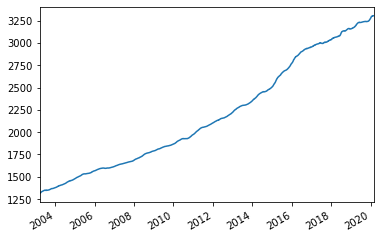

In [14]:
df_vna.plot()

---
## Pricing the Bonds

First we just arrange the daily data we are going to use (VNA and the bond yields) in a DataFrame.

In [15]:
df = pd.concat([df['VNA'], df_diario['Yield B50']], axis=1).dropna(how='all')
df['Yield B50'] = df['Yield B50'].fillna(method='ffill')
df = df.dropna(how='any')
df['Cupom'] = 0

display(df)

,VNA,Yield B50,Cupom
2012-06-19,2155.68,4.942,0
2012-06-20,2155.88,4.876,0
2012-06-21,2156.09,4.865,0
2012-06-22,2155.88,4.757,0
2012-06-25,2156.01,4.680,0
2012-06-26,2156.13,4.680,0
2012-06-27,2156.25,4.680,0
2012-06-28,2156.38,4.680,0
2012-06-29,2156.5,4.745,0
2012-07-02,2156.62,4.710,0


The following cell creates a series of the 15ths of every august and february. I suggest reading the documentation for `pd.date_range` to understand exatcly how it is doing so. After that it checks if it is a business day and if it is not, grabs the next following day.

In [16]:
dcf_dates = pd.date_range(start='2012-08-15', end='2050-08-15', freq='12SMS')
dcf_dates = dc.busdateroll(dcf_dates, 'following')
df_dcf = pd.DataFrame(index=dcf_dates)

Now, for each day, it builds the cashflows of the bonds, finds the daycounts for all of them, disccount them using the yield for that day and saves it. It also checks if there is coupon payments on that date and, if so, saves its value.

In [17]:
for d in tqdm(df.index, 'Pricing'):

    vna_d = df.loc[d, 'VNA']
    rate_d = df.loc[d, 'Yield B50']/100

    df_dcf['DU'] = dc.days(d, df_dcf.index)

    df_dcf['Fluxo'] = ((1.06**0.5) - 1) * vna_d
    df_dcf.loc['2050-08-15', 'Fluxo'] = df_dcf.loc['2012-08-15', 'Fluxo'] + vna_d

    df_dcf['Fluxo Descontado'] = df_dcf['Fluxo']/((1+rate_d)**(df_dcf['DU']/252))
    df.loc[d, 'PU'] = df_dcf['Fluxo Descontado'].sum()

    if d in dcf_dates:
        df.loc[d, 'Cupom'] = ((1.06**0.5) - 1) * vna_d

Pricing: 100%|██████████| 1942/1942 [00:05<00:00, 346.00it/s]


Now we have a series for the price of the NTN-Bs which is not yet our tracker, since we still have to take the coupon payments into account.

---
# Building the Tracker
By dividing the columns of coupon payments by the column of the price of the bond, we get how many bonds we can buy on the coupon paying dates. We have to be careful to shift dates by one day, in order to match the dates that we actually get the cash from the coupon.

We then multiply the ammount of bonds we are holding by their price to get the notional of our portfolio.

In [19]:
df['Quantidade'] = 1 + (df['Cupom'].shift(1, fill_value=0)/df['PU']).expanding().sum()
df['Notional'] = df['Quantidade']*df['PU']

The chart below shows how the holdings of bonds increases over time with the coupon payments.

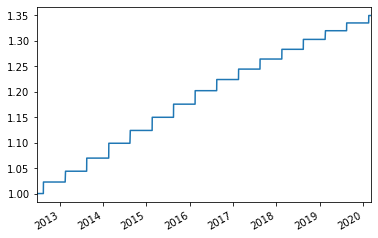

In [20]:
df['Quantidade'].plot()

This one shows the difference between the bond price (PU) an the total return index (Notional)

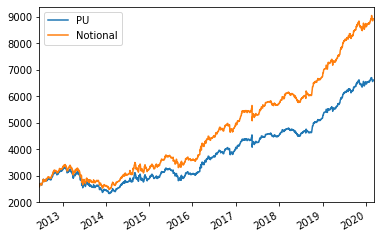

In [21]:
df[['PU', 'Notional']].plot()

The percent returns of both series are very similar. In fact they only differ on the dates of coupon payments.

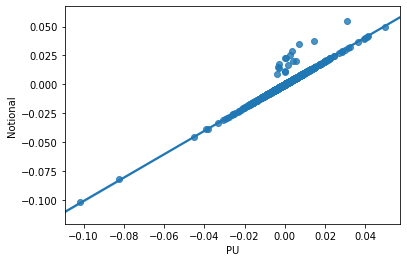

In [23]:
import seaborn
seaborn.regplot(data=df[['PU', 'Notional']].pct_change(1), x='PU', y='Notional')